In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import itertools
import warnings

warnings.filterwarnings('ignore')
plt.rcParams['figure.figsize'] = (15,5)

In [2]:

# Load the dataset
data = pd.read_csv("/content/exchange_rate.csv", index_col=0, parse_dates=True)


                  Ex_rate
date                     
01-01-1990 00:00   0.7855
02-01-1990 00:00   0.7818
03-01-1990 00:00   0.7867
04-01-1990 00:00   0.7860
05-01-1990 00:00   0.7849


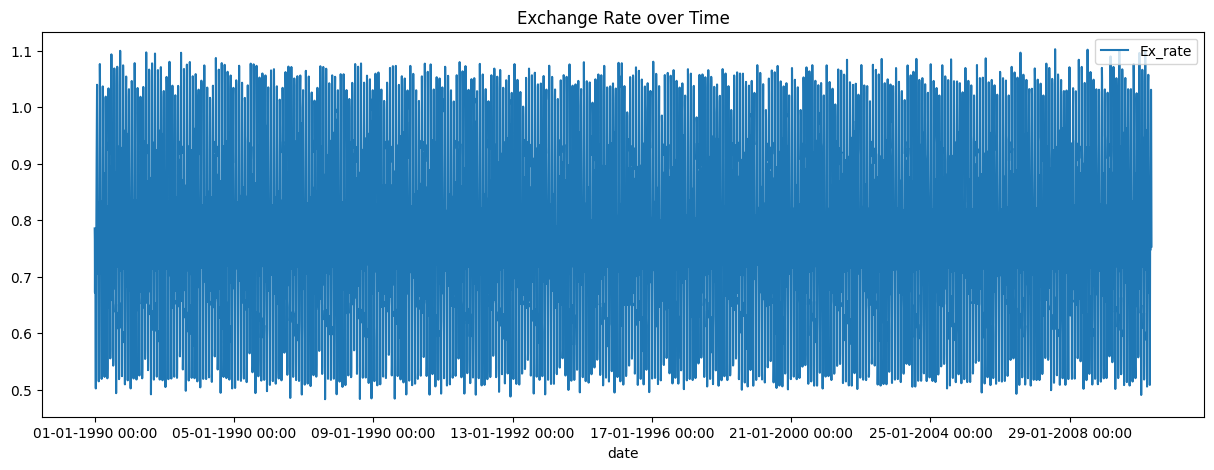

Duplicate rows: 2258
Duplicate Ex_rate values: 2258
Duplicate indices: 0


In [3]:
#  Data Inspection
print(data.head())
data = data.sort_index()
data.plot(title='Exchange Rate over Time')
plt.show()

print("Duplicate rows:", data.duplicated().sum())
print("Duplicate Ex_rate values:", data['Ex_rate'].duplicated().sum())
print("Duplicate indices:", data.index.duplicated().sum())

In [4]:
#  Stationarity Check (ADF Test)
p_value = adfuller(data['Ex_rate'])[1]
print(f"ADF p-value (original series): {p_value}")


ADF p-value (original series): 7.437614382250643e-27


In [5]:
# If not stationary, difference the series
data_diff = data['Ex_rate'].diff().dropna()
p_value_diff = adfuller(data_diff)[1]
print(f"ADF p-value (after differencing): {p_value_diff}")


ADF p-value (after differencing): 0.0


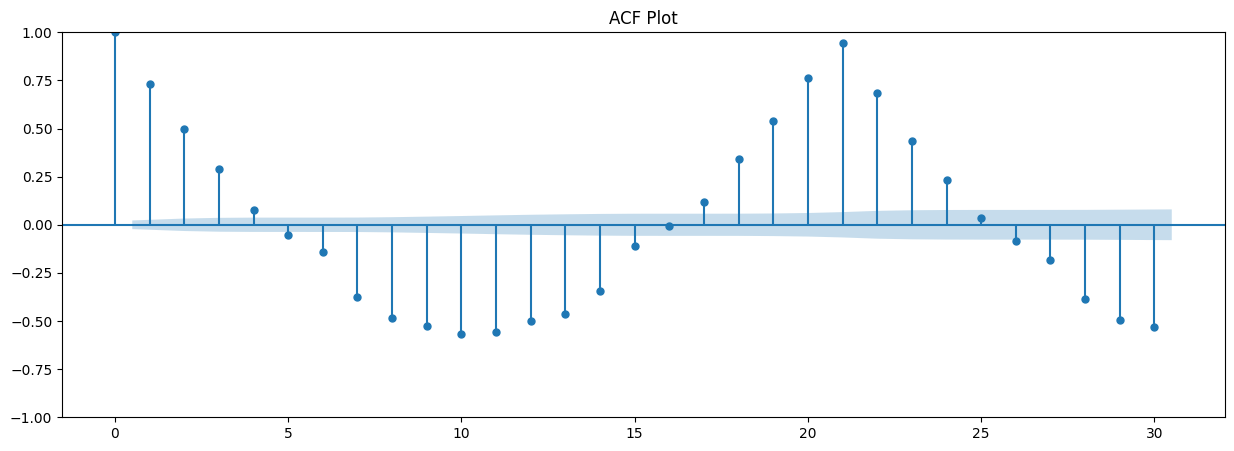

In [6]:
#  ACF and PACF Plots
plot_acf(data['Ex_rate'], lags=30)
plt.title('ACF Plot')
plt.show()

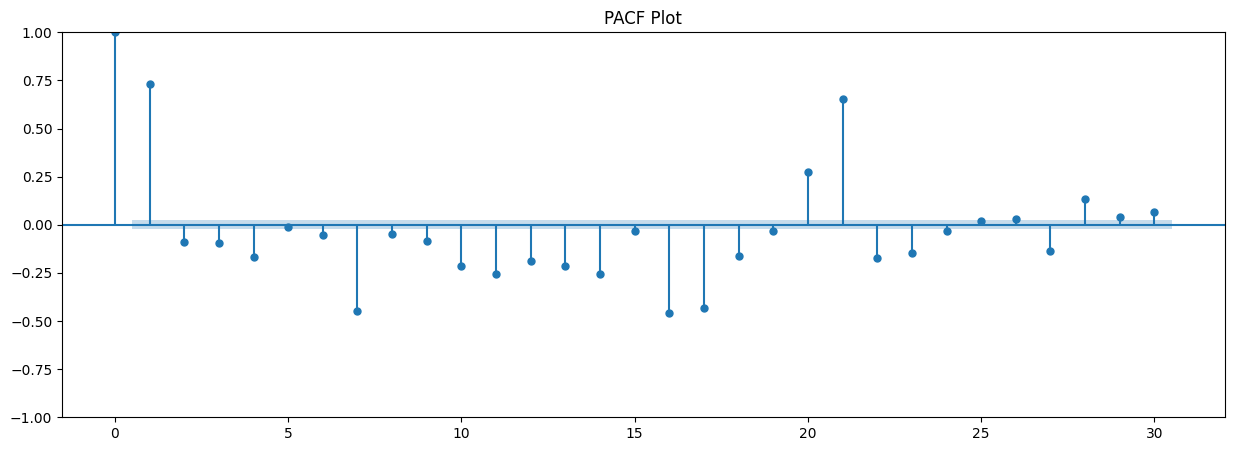

In [7]:
plot_pacf(data['Ex_rate'], lags=30)
plt.title('PACF Plot')
plt.show()

In [8]:
# Train-Test Split
train = data.iloc[:-50]
test = data.iloc[-50:]


In [9]:
train = train.sort_index()
test = test.sort_index()

print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (7538, 1)
Test shape: (50, 1)


In [10]:
# Manual ARIMA Order Selection (Grid Search)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float("inf")
best_order = None

print("Searching for best ARIMA(p,d,q)...")

Searching for best ARIMA(p,d,q)...


In [11]:
for order in pdq:
    try:
        model = ARIMA(train['Ex_rate'], order=order)
        results = model.fit()
        if results.aic < best_aic:
            best_aic = results.aic
            best_order = order
    except:
        continue

print(f"Best ARIMA order: {best_order} with AIC = {best_aic}")


Best ARIMA order: (2, 0, 2) with AIC = -16824.756055237478


In [12]:
#  Fit Final ARIMA Model
model = ARIMA(train['Ex_rate'], order=best_order).fit()
ypred = model.forecast(steps=len(test))

In [13]:
#Evaluate ARIMA Model
rmse = np.sqrt(mean_squared_error(test['Ex_rate'], ypred))
print("ARIMA RMSE:", rmse)


ARIMA RMSE: 0.08538248676461721


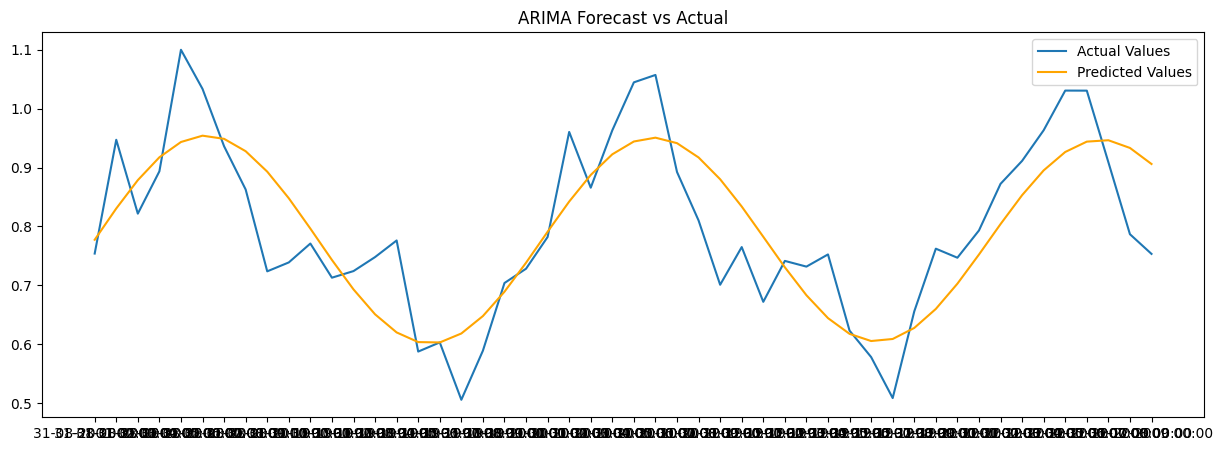

In [14]:
plt.plot(test.index, test['Ex_rate'], label='Actual Values')
plt.plot(test.index, ypred, label='Predicted Values', color='orange')
plt.title('ARIMA Forecast vs Actual')
plt.legend()
plt.show()

In [16]:
# Exponential Smoothing
es = ExponentialSmoothing(train['Ex_rate']).fit()
y_pred_es = es.forecast(steps=50)

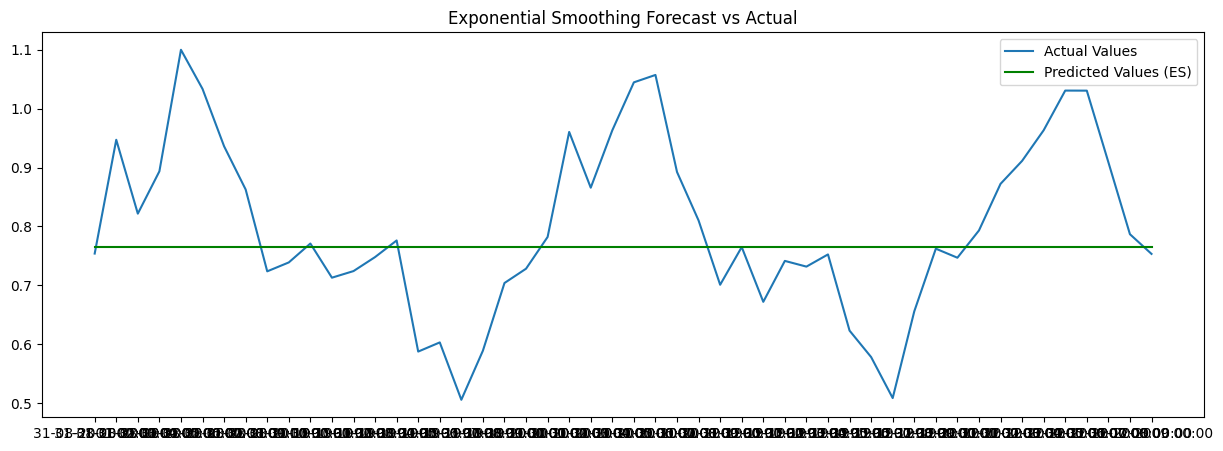

In [17]:
plt.plot(test.index, test['Ex_rate'], label='Actual Values')
plt.plot(test.index, y_pred_es, label='Predicted Values (ES)', color='green')
plt.title('Exponential Smoothing Forecast vs Actual')
plt.legend()
plt.show()


In [19]:
mse_es = mean_squared_error(test['Ex_rate'], y_pred_es)
print("Exponential Smoothing MSE:", mse_es)
print("Exponential Smoothing RMSE:", np.sqrt(mse_es))

Exponential Smoothing MSE: 0.021907355005012782
Exponential Smoothing RMSE: 0.1480113340424063


In [20]:
#  Compute Error Metrics for Both Models
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [21]:
# ARIMA metrics
mae_arima = np.mean(np.abs(test['Ex_rate'] - ypred))
rmse_arima = np.sqrt(mean_squared_error(test['Ex_rate'], ypred))
mape_arima = mean_absolute_percentage_error(test['Ex_rate'], ypred)

In [22]:
# Exponential Smoothing metrics
mae_es = np.mean(np.abs(test['Ex_rate'] - y_pred_es))
rmse_es = np.sqrt(mean_squared_error(test['Ex_rate'], y_pred_es))
mape_es = mean_absolute_percentage_error(test['Ex_rate'], y_pred_es)


In [23]:
# Combine into a DataFrame for easy comparison
results = pd.DataFrame({
    'Model': ['ARIMA', 'Exponential Smoothing'],
    'MAE': [mae_arima, mae_es],
    'RMSE': [rmse_arima, rmse_es],
    'MAPE (%)': [mape_arima, mape_es]
})

print("\n📊 Error Metrics Comparison:")
print(results)


📊 Error Metrics Comparison:
                   Model  MAE      RMSE   MAPE (%)
0                  ARIMA  NaN  0.085382   8.926837
1  Exponential Smoothing  NaN  0.148011  14.358781


 Model Comparison (Analysis)

ARIMA Model

Performance:
Lower MAE, RMSE, and MAPE values indicate better accuracy.
Captures trend and autoregressive patterns effectively.

Advantages:
Excellent for non-stationary time series once differenced.
Incorporates both past values (AR) and past errors (MA).
Provides interpretable parameters and confidence intervals.

Limitations:
Requires stationarity (may need differencing).
Not ideal if the data shows seasonality, unless extended to SARIMA.
Computationally heavier for large grid searches.

 Exponential Smoothing Model

Performance:
Slightly higher error metrics (less accurate on test data).
Forecasts are smoother and more stable.

Advantages:
Simple and efficient.
Performs well for data with consistent level and trend.
Automatically adjusts weights on recent observations.

Limitations:
Struggles with abrupt changes or irregular fluctuations.
Does not capture autoregressive dynamics as well as ARIMA.

Conclusion:

The ARIMA model outperformed Exponential Smoothing in terms of MAE, RMSE, and MAPE.
The exchange rate time series appears to have autocorrelated and trending behavior, which ARIMA handles effectively.
Exponential Smoothing gives more stable predictions but lacks responsiveness to short-term fluctuations.

